# Introducción

El presente notebook consta de la resolución del ejercicio 2 del Trabajo Práctico N° 1 de la asignatura Aprendizaje Automático II de TUIA, cuyo objetivo es analizar el dataset proporcionado e implementar un modelo de red neuronal de clasificación capaz de predecir la variable objetivo.




Integrantes:

- Ferrari, Enzo
- Pozzo, Micaela
- Rodriguez, Abril



# Librerías

In [27]:
%%capture
!pip install tensorflow
!pip install -q gdown

In [29]:
# Carga del dataset
import gdown
import zipfile

# Manejo y visualización de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Red neuronal de Clasificación
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from keras.regularizers import l1_l2
from keras.optimizers import Adam

# Análisis exploratorio

Comenzamos cargando el csv '*diabetes.csv*' dentro de la variable '**data_diabetes**'

In [33]:
gdown.download('https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_')

with zipfile.ZipFile('TP1-2-diabetes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-2')

data_diabetes = pd.read_csv('TP1-2/diabetes.csv')

Downloading...
From: https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_
To: /content/TP1-2-diabetes.zip
100%|██████████| 9.13k/9.13k [00:00<00:00, 7.79MB/s]


El dataset cuenta con 768 observaciones y 9 columnas: 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age' y 'Outcome'.

Todas ellas son numéricas, conteniendo la mayoría tipos de datos enteros, a excepción de 'BMI' y 'DiabetesPedigreeFunction', que contienen flotantes.

No posee valores duplicados.

En cuanto a valores nulos, parece ser que no hay. Pero más adelante veremos que sí existen y están marcados con el valor 0.

In [32]:
data_diabetes.info()

print("\n\n Duplicados: ", data_diabetes.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


 Duplicados:  0


Para comprender el comportamiento de cada variable en el conjunto de datos, emplearemos el método 'describe' y graficaremos cada una de ellas.

In [5]:
data_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Para obtener una visualización más gráfica, generaremos un histograma y un boxplot para cada variable numérica, excluyendo la variable objetivo, la cual abordaremos por separado más adelante.

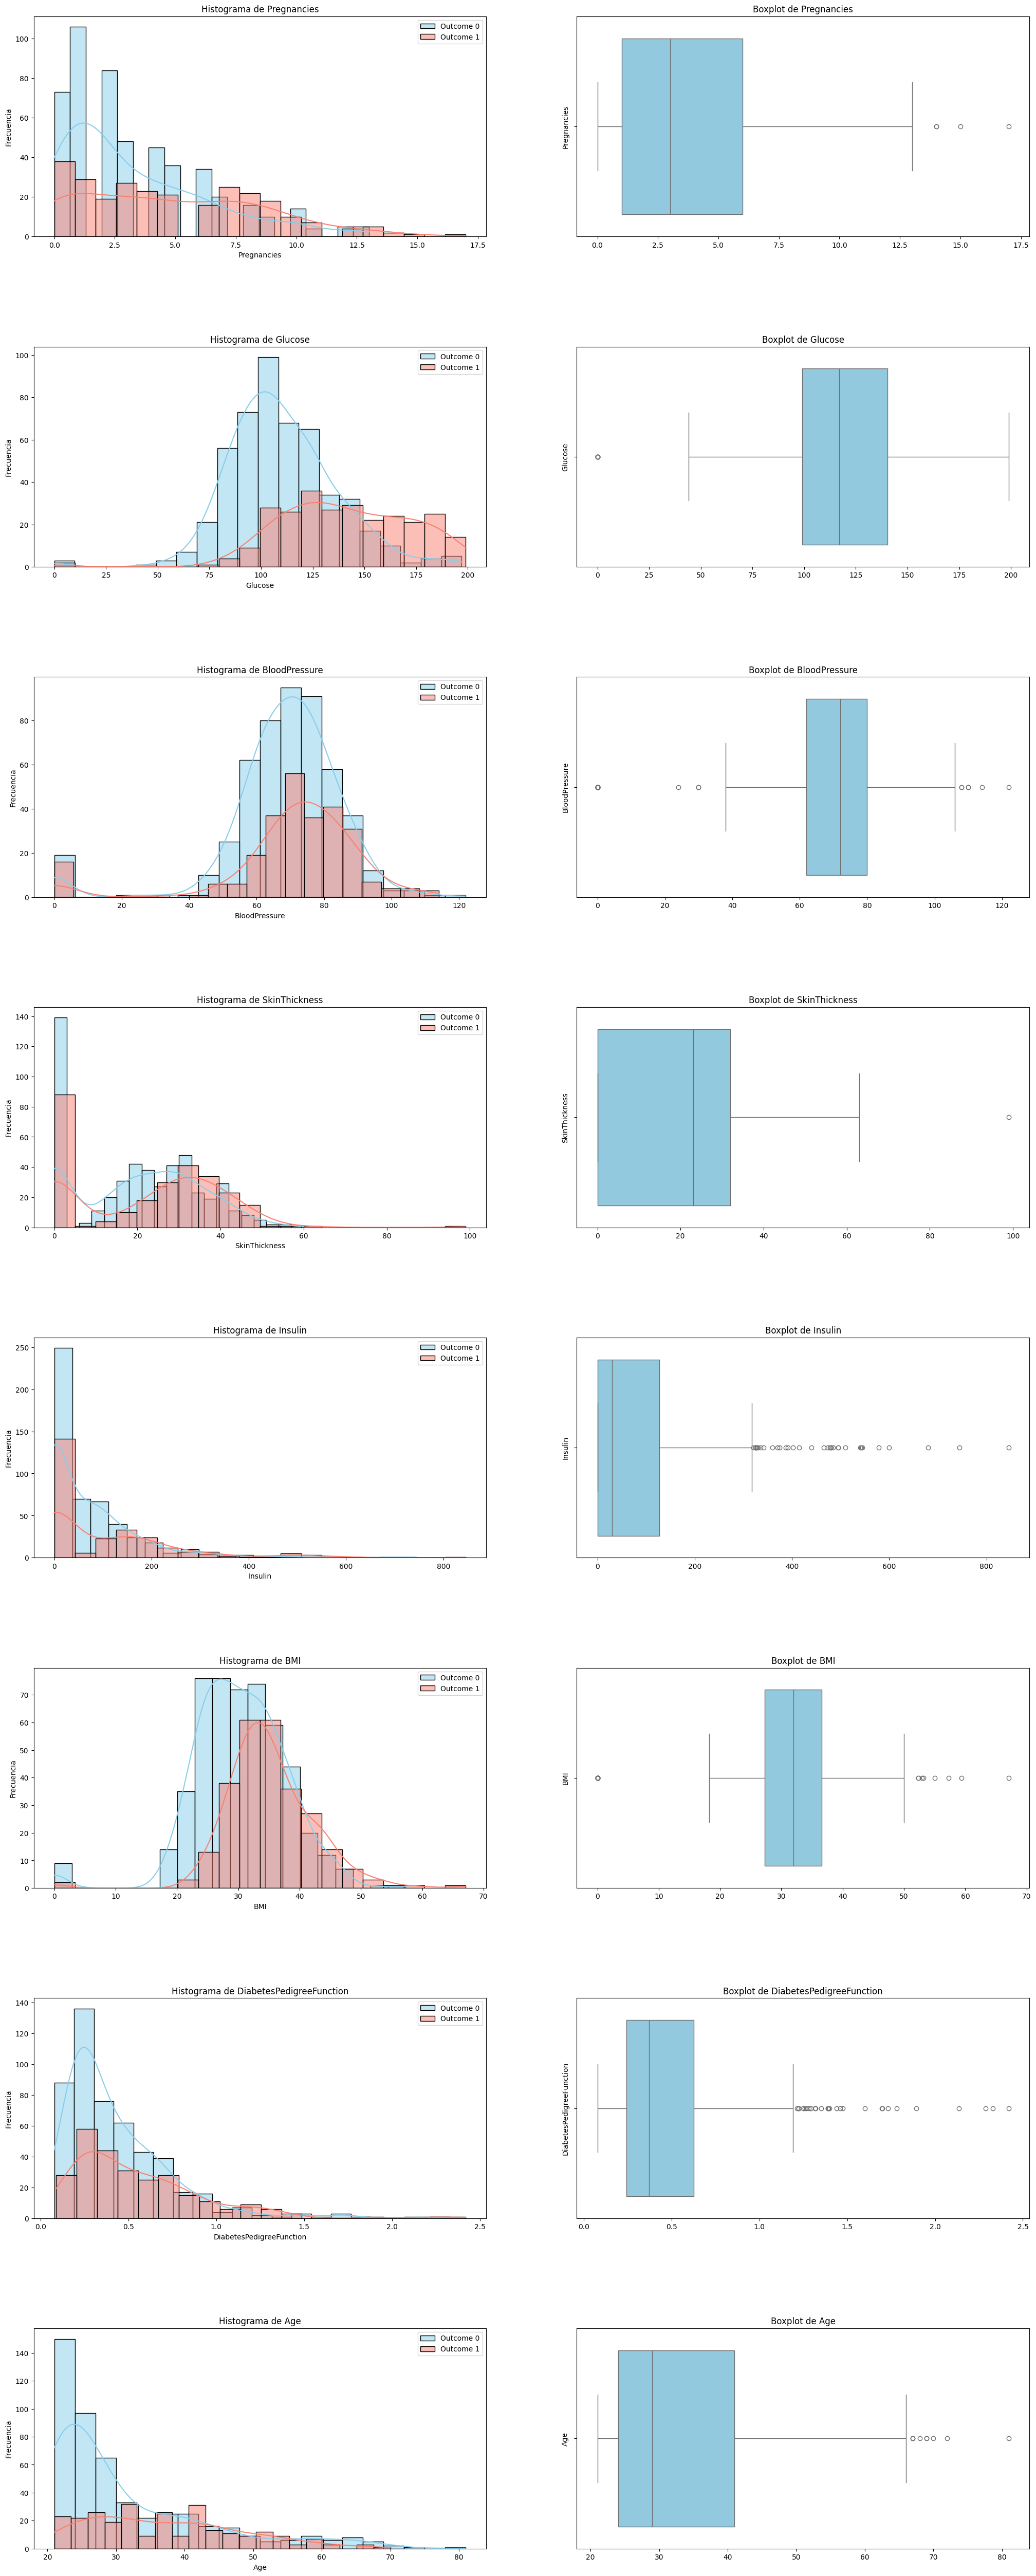

In [6]:
def plot_histogram_boxplots(df, columns):
    num_cols = len(columns)

    fig, axes = plt.subplots(num_cols, 2, figsize=(25, 8*num_cols))
    fig.subplots_adjust(hspace=0.5)

    for i, column in enumerate(columns):
        ax_hist = axes[i, 0]
        ax_box = axes[i, 1]

        sns.histplot(df[df['Outcome'] == 0][column], bins=20, kde=True, ax=ax_hist, color='skyblue', label='Outcome 0')
        sns.histplot(df[df['Outcome'] == 1][column], bins=20, kde=True, ax=ax_hist, color='salmon', label='Outcome 1')
        ax_hist.set_title(f'Histograma de {column}')
        ax_hist.set_xlabel(column)
        ax_hist.set_ylabel('Frecuencia')
        ax_hist.legend()

        sns.boxplot(x=df[column], ax=ax_box, color='skyblue')
        ax_box.set_title(f'Boxplot de {column}')
        ax_box.set_xlabel('')
        ax_box.set_ylabel(column)

    plt.show()

# Uso de la función
plot_histogram_boxplots(data_diabetes, data_diabetes.drop('Outcome', axis=1).columns)

Al analizar los histogramas de ciertas variables, notamos la presencia de valores '0' en casos donde su ocurrencia es extremadamente improbable. Esto se evidencia en las variables 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' y 'BMI'. Esta observación sugiere que estos valores son registros desconocidos en lugar de verdaderos ceros.

Para abordar esta situación, hemos decidido tratar estos valores como nulos y sustituirlos por la mediana correspondiente. Sin embargo, este procedimiento será llevado a cabo en la próxima sección, en el pre-procesamiento de datos, asegurándonos de aplicar estos cambios exclusivamente al conjunto de entrenamiento. Esto es necesario para evitar cualquier fuga de datos, ya que no podemos realizar modificaciones en el conjunto de prueba.

En cuanto al análisis, observamos que para los individuos diabéticos, la mayoría de las variables muestran una leve tendencia hacia la derecha. Por ejemplo, parece que las personas diabéticas tienden a tener valores más altos en 'SkinThickness', 'Insulin' y 'BMI'.

Además, en ciertos casos como 'Pregnancies', 'Insulin', 'DiabetesPedrigreeFunction' y 'Age', la mayoría de las observaciones se concentran en valores más bajos, lo que resulta en un sesgo hacia la derecha y la aparición de valores atípicos cuando se presentan valores muy altos.

Este fenómeno se refleja en los boxplots, donde se pueden identificar algunos valores atípicos. Dado que todos los modelos se ven influenciados por estos valores, consideramos la posibilidad de ajustarlos tomando en cuenta los bigotes de cada boxplot. Sin embargo, al final no implementamos esta técnica porque no presentó buenos resultados en los modelos.

Ahora nos enfocaremos en analizar la variable objetivo. Esta variable ya está preparada para su uso en modelos, dado que está categorizada numéricamente, donde el valor 0 representa a una persona sana y el valor 1 a una persona diabética.

Para comprender su distribución, generaremos un gráfico de barras adaptando la variable a una forma categórica. Esto nos permitirá una mejor visualización y comprensión de los datos.

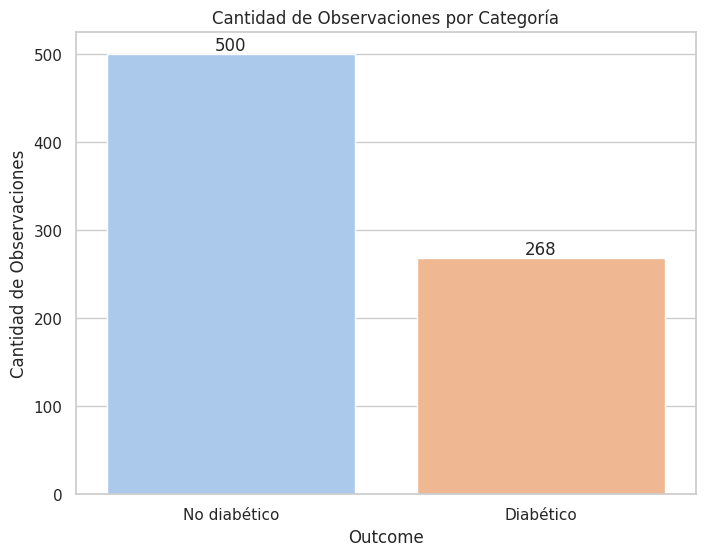

In [261]:
def plot_outcomes(df):
    '''Realiza un gráfico de barras de la variable objetivo'''
    df_temp = df.copy()
    df_temp['Outcome_categorica'] = df_temp['Outcome'].map({0: 'No diabético', 1: 'Diabético'}) # Mapeo los valores de la columna 'Outcome' a 'No diabético' y 'Diabético'

    counts = df_temp['Outcome_categorica'].value_counts() # Cuento la cantidad de observaciones para cada categoría

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="pastel", legend=False)
    plt.title('Cantidad de Observaciones por Categoría')
    plt.xlabel('Outcome')
    plt.ylabel('Cantidad de Observaciones')

    for index, value in enumerate(counts.values):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.show()


plot_outcomes(data_diabetes) # llamada a la función

El dataset cuenta con 268 observaciones de personas diagnosticadas con diabetes, y 500 que no. Esto nos indica que el conjunto de datos está desbalanceado, ya que el número de casos de diabetes representa aproximadamente la mitad de los casos no diabéticos.

Esto será tratado más adelante, antes de entrenar el modelo de red neuronal.

Finalmente, procederemos a generar un gráfico de mapa de calor con el objetivo de visualizar los coeficientes de correlación de Pearson entre cada par de variables.

Este gráfico nos alertará de posibles relaciones lineales entre las variables.

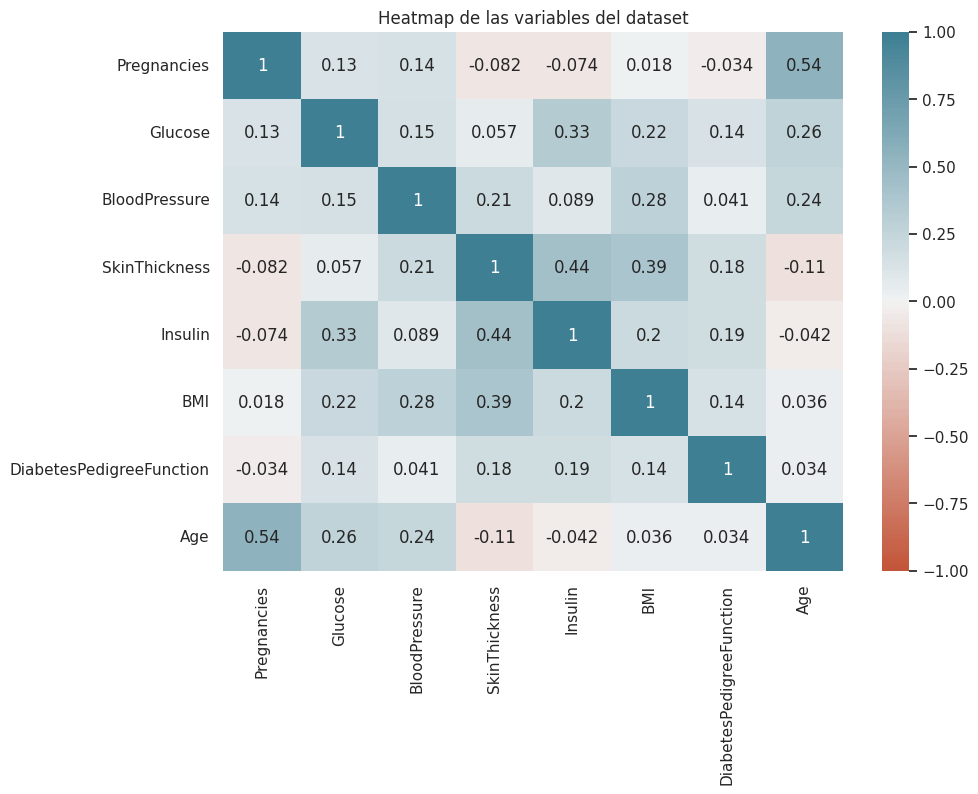

In [262]:
def plot_heatmap(df):
    '''Recibe un dataframe y grafica el mapa de calor
    para correlaciones entre sus variables.'''

    matrix_corr = df.corr()
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(
        matrix_corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        annot=True
    )
    plt.title('Heatmap de las variables del dataset')
    plt.show()

plot_heatmap(data_diabetes.drop('Outcome', axis=1))

El mapa de calor no nos sugiere ninguna relación lineal entre variables.

En caso de que hubiera habido algún par de variables con un coeficiente elevado, evaluaríamos si es relevante incluir ambas variables al entrenar el modelo.

# Preprocesamiento y división en train-test

Primero, dividiremos el conjunto de datos en 'X_diabetes' e 'y_diabetes', donde 'X_diabetes' contendrá las variables independientes y 'y_diabetes' la variable a predecir, que es 'Outcome'.

Posteriormente, procederemos a dividir el conjunto de datos en conjuntos de entrenamiento y prueba, asignando un tamaño de prueba del 20%.

In [263]:
X_diabetes = data_diabetes.drop('Outcome', axis=1)
y_diabetes = data_diabetes['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.2, random_state = 42)

Hemos visto que el conjunto de datos presenta valores contabilizados como '0' en columnas donde no es posible obtener ese valor. Estos '0' indican valores faltantes y deben ser tratados.

Para evitar la fuga de datos (ya que la práctica no tenemos poder de alterar los valores del conjunto de prueba) y garantizar que nuestro modelo sea robusto y generalice bien a datos nuevos, calcularemos la mediana de cada columna del conjunto de entrenamiento, considerando la clase a la que pertenece cada observación. Luego, usaremos dichas medianas para reemplazar los valores '0' tanto en el conjunto X de entrenamiento como en el conjunto X de prueba.

Aplicaremos este criterio sobre las columnas 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI' porque acordamos que son las variables que no pueden contener como valor el número 0, y por lo tanto son considerados como desconocidos o nulos.

In [264]:
X_train_nan = X_train.replace(0, np.nan) # reemplazamos los valores '0' por NaN

median_values_class_0 = X_train_nan[y_train == 0][['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median()  # mediana para clase 0 (no diabéticos)
median_values_class_1 = X_train_nan[y_train == 1][['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median()  # mediana para clase 1 (diabéticos)

for col in median_values_class_0.index:
    X_train.loc[(y_train == 0) & (X_train[col] == 0), col] = median_values_class_0[col]  # reemplazamos los valores '0' por la mediana correspondiente para la clase 0

for col in median_values_class_1.index:
    X_train.loc[(y_train == 1) & (X_train[col] == 0), col] = median_values_class_1[col]  # reemplazamos los valores '0' por la mediana correspondiente para la clase 1

El siguiente código reemplaza los valores '0' por NaN en X_test y luego reemplaza esos valores NaN por las medianas correspondientes de cada columna de X_train. De esta manera, los valores '0' en X_test se transformarán en las medianas calculadas previamente en X_train.

In [265]:
X_test_nan = X_test.replace(0, np.nan) # reemplazamos los valores '0' por NaN

for col in median_values_class_0.index:
    X_test.loc[X_test_nan[col].isnull(), col] = median_values_class_0[col] # reemplazamos los valores '0' en X_test por las medianas correspondientes de X_train para la clase 0

for col in median_values_class_1.index:
    X_test.loc[X_test_nan[col].isnull(), col] = median_values_class_1[col] # reemplazamos los valores '0' en X_test por las medianas correspondientes de X_train para la clase 1

Luego, el segundo cambio que realizaremos es balancear el dataset, ya que una clase predomina sobre otra. Es por eso que hemos decidido aplicar oversampling a la variable minoritaria ('Outcomes' = 1) para contrarrestar el sesgo por desbalance durante el entrenamiento del modelo.

Para ello, a partir del conjunto de entrenamiento, calcularemos cuántas observaciones se corresponden a cada clase. Luego, mediante 'resample', haremos oversampling sobre la clase minoritaria (la clase diabética) y obtendremos así un 'X_train' y un 'y_train' balanceados.

In [266]:
df_train = pd.concat([pd.DataFrame(X_train, columns=X_diabetes.columns), pd.Series(y_train, name='Outcome')], axis=1)  # concateno en un df de entrenamiento

clase_minoritaria = df_train[df_train['Outcome'] == 1]  # diabéticos
clase_mayoritaria = df_train[df_train['Outcome'] == 0]  # no diabéticos

clase_minoritaria_resampled = resample(clase_minoritaria, replace=True, n_samples=len(clase_mayoritaria), random_state=42)  # aplico resample sobre la clase minoritaria

df_train_balanceado = pd.concat([clase_mayoritaria, clase_minoritaria_resampled]) # concateno clases ya balanceadas

X_train_balanceado = df_train_balanceado.drop('Outcome', axis=1)
y_train_balanceado = df_train_balanceado['Outcome']

A continuación, vemos un gráfico de barras para cada clase luego de balancear X_train

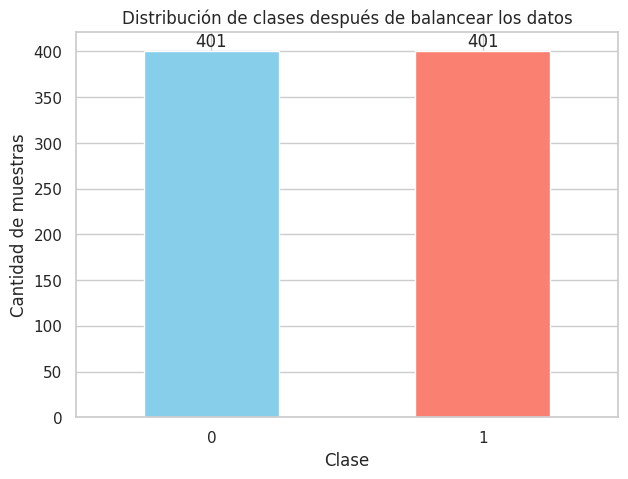

In [267]:
def distribucion_balanceada(df_balanceado):
  counts = df_balanceado['Outcome'].value_counts()
  plt.figure(figsize=(7, 5))
  counts.plot(kind='bar', color=['skyblue', 'salmon'])
  plt.title('Distribución de clases después de balancear los datos')
  plt.xlabel('Clase')
  plt.ylabel('Cantidad de muestras')
  plt.xticks(rotation=0)
  for i, count in enumerate(counts):
      plt.text(i, count, str(count), ha='center', va='bottom')

  plt.show()

distribucion_balanceada(df_train_balanceado)

Por último, al analizar los boxplot, observamos que la variable de insulina contiene valores atípicos altos, generando una asimetría hacia la derecha y ampliando su rango en comparación con otras variables.

Por eso, estandarizaremos las variables explicativas ya que presentan una escala muy diferente unas de otras.

In [268]:
scaler = StandardScaler()

X_train_balanceado = scaler.fit_transform(X_train_balanceado) # estandarizamos X_train_balanceado

X_test_estand = scaler.transform(X_test) # aplicamos la misma transformación a X_test utilizando la media y la desviación estándar de X_train_balanceado

# Redes Neuronales

Una vez aplicado el preprocesamiento de los datos, procederemos a implementar tres modelos diferentes de redes neuronales. El objetivo es explorar diversas arquitecturas y encontrar aquella que ofrezca la mejor capacidad predictiva.

## Modelo 1

Comencemos definiendo un modelo con 3 capas densas. La primera de ellas, de 13 neuronas, la segunda con 8 y la última con una única neurona. Para las dos primeras, la función de activación será 'relu', mientras que para la capa final, la función de activación necesariamente será la sigmoidea, ya que se trata de un problema de clasificación binaria.

La razón por la cual decidimos comenzar con un modelo sencillo de únicamente tres capas y pocas neuronas es porque contamos con un dataset relativamente pequeño y poco complejo, por lo tanto no quisiéramos complejizar por demás la red. Por la misma razón, optamos en setear las épocas en 200 y no utilizar el parámetro batch_size.

In [278]:
model_1 = Sequential([
    Input(shape=(X_train_balanceado.shape[1],)),
    Dense(13, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.summary()

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_1 = model_1.fit(X_train_balanceado, y_train_balanceado, epochs=200, validation_split=0.2)

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_586 (Dense)           (None, 13)                117       
                                                                 
 dense_587 (Dense)           (None, 8)                 112       
                                                                 
 dense_588 (Dense)           (None, 1)                 9         
                                                                 
Total params: 238 (952.00 Byte)
Trainable params: 238 (952.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
21/21 [==============================] - 1s 14ms/step - loss: 0.6928 - accuracy: 0.5913 - val_loss: 0.8933 - val_accuracy: 0.1677
Epoch 2/200
21/21 [==============================] - 0s 7ms/step - loss: 0.6661 - accuracy: 0.6708 - val_loss: 0.8681 - val_accuracy: 0.

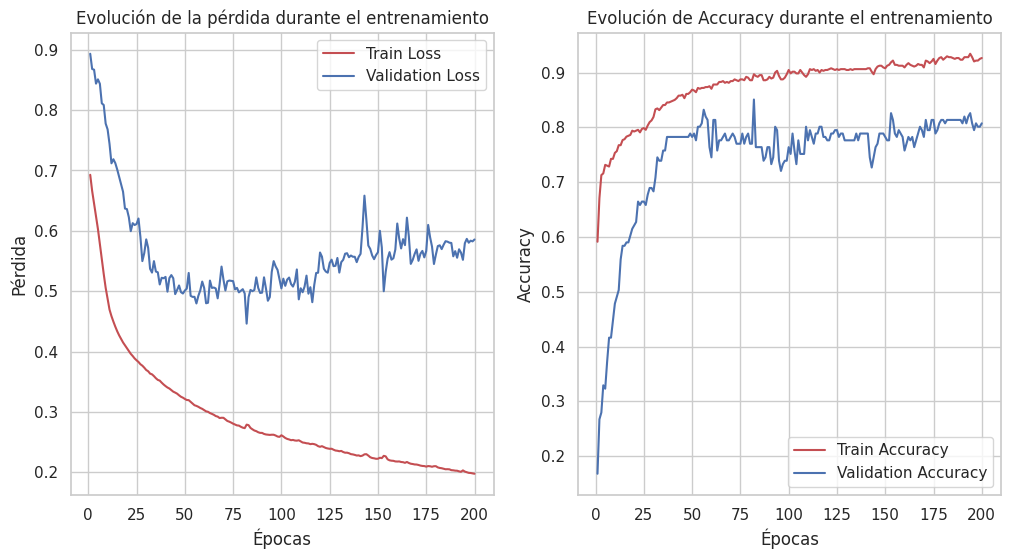

In [279]:
def evolucion_perdidas_y_accuracy(history):
    '''Grafica las pérdidas y el acurracy del conjunto de entrenamiento y prueba
    a lo largo de las épocas'''
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Evolución de la pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'r', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Evolución de Accuracy durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

evolucion_perdidas_y_accuracy(history_1)

En ambos gráficos, se observa cómo el modelo overfittea/sobreajusta. Esto se refleja en un error muy bajo para los datos de entrenamiento, mientras que los datos de prueba muestran errores más altos en comparación.

Además, tanto los errores como el accuracy de los datos de prueba muestran fluctuaciones a lo largo de las épocas, mientras que los datos de entrenamiento muestran un progreso más constante y fluido.

In [280]:
def metricas(y_true, y_pred, set_name):
    '''Calcula métricas y muestra el reporte de clasificación'''
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f'\n {set_name} Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('\n\nClassification Report: \n')
    print(report)
    print()

# métricas de entrenamiento
y_train_pred = (model_1.predict(X_train_balanceado) > 0.5).astype("int32")
metricas(y_train_balanceado, y_train_pred, 'Train')

# métricas de prueba
y_test_pred = (model_1.predict(X_test_estand) > 0.5).astype("int32")
metricas(y_test, y_test_pred, 'Test')

26/26 [==============================] - 0s 1ms/step

 Train Metrics:
Accuracy: 0.9040
Precision: 0.9355
Recall: 0.8678


Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       401
           1       0.94      0.87      0.90       401

    accuracy                           0.90       802
   macro avg       0.91      0.90      0.90       802
weighted avg       0.91      0.90      0.90       802


5/5 [==============================] - 0s 2ms/step

 Test Metrics:
Accuracy: 0.6039
Precision: 0.4651
Recall: 0.7273


Classification Report: 

              precision    recall  f1-score   support

           0       0.78      0.54      0.63        99
           1       0.47      0.73      0.57        55

    accuracy                           0.60       154
   macro avg       0.62      0.63      0.60       154
weighted avg       0.67      0.60      0.61       154




Los resultados muestran que el modelo tiene un buen desempeño en el conjunto de entrenamiento. Esto se refleja en las métricas generales y en el informe de clasificación, donde tanto la clase positiva/diabética (1) como la clase negativa/no diabética (0) tienen puntajes de precisión, sensibilidad y puntuación F1 bastante altos.

Sin embargo, en el conjunto de prueba, el modelo tiene dificultades para generalizar.

Aunque la exactitud/accuracy (0.60) nos sugiere que las predicciones realizadas por el modelo son correctas en más de la mitad de los casos, la precision y recall para la clase diabética (1) son más bajas. Esto sugiere que el modelo está teniendo problemas para identificar correctamente los casos positivos en el conjunto de prueba, lo que se refleja en un puntaje F1 más bajo para la clase positiva/diabética en comparación con la clase negativa.

En resumen, el modelo parece estar sobreajustando los datos de entrenamiento y no generalizando bien a nuevos datos, especialmente en lo que respecta a la identificación de los casos con diabetes en el conjunto de prueba. Es posible que se necesiten ajustes en el modelo o en el conjunto de datos para mejorar su capacidad de generalización.

## Modelo 2

A continuación, probaremos definiendo otra arquitectura para la red neuronal, esperando así que se brinden mejores resultados que los anteriores.

Para ello, cambiaremos un poco la red en cuanto a cantidad de neuronas, pero añadiendo dropout para evitar el sobreajuste que presentaba el modelo anterior.

Aquí nos dimos cuenta que la función de activación 'tanh' brinda mejores resultados que 'relu'.

In [294]:
model_2 = Sequential([
    Input(shape=(X_train_balanceado.shape[1],)),
    Dense(16, activation='tanh'),
    Dropout(0.1),
    Dense(4, activation='tanh'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model_2.summary()

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(X_train_balanceado, y_train_balanceado, epochs=150, validation_split=0.2)

Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_604 (Dense)           (None, 16)                144       
                                                                 
 dropout_420 (Dropout)       (None, 16)                0         
                                                                 
 dense_605 (Dense)           (None, 4)                 68        
                                                                 
 dropout_421 (Dropout)       (None, 4)                 0         
                                                                 
 dense_606 (Dense)           (None, 1)                 5         
                                                                 
Total params: 217 (868.00 Byte)
Trainable params: 217 (868.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
21

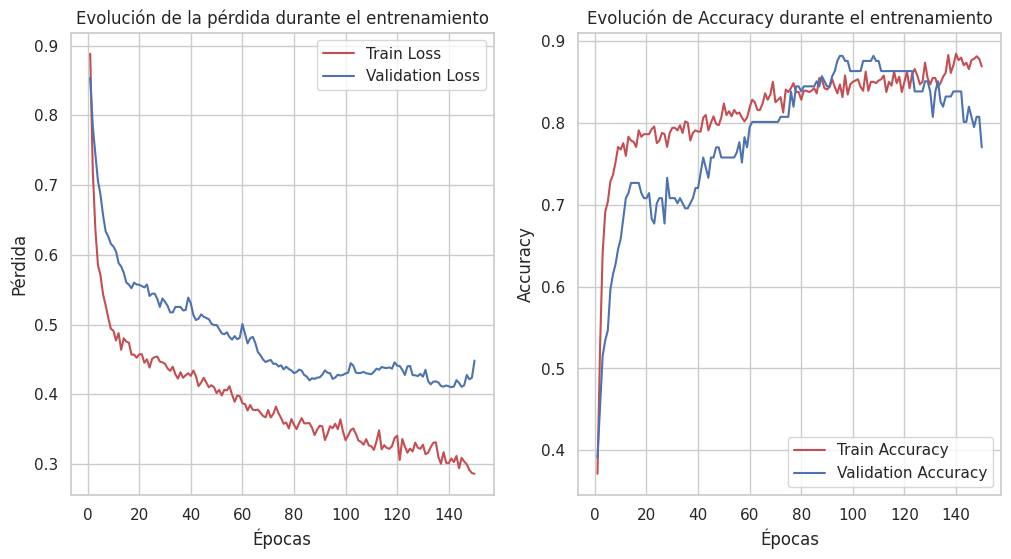

In [295]:
evolucion_perdidas_y_accuracy(history_2)

In [296]:
# métricas de entrenamiento
y_train_pred = (model_2.predict(X_train_balanceado) > 0.5).astype("int32")
metricas(y_train_balanceado, y_train_pred, 'Train')

# métricas de prueba
y_test_pred = (model_2.predict(X_test_estand) > 0.5).astype("int32")
metricas(y_test, y_test_pred, 'Test')

26/26 [==============================] - 0s 1ms/step

 Train Metrics:
Accuracy: 0.8678
Precision: 0.9063
Recall: 0.8204


Classification Report: 

              precision    recall  f1-score   support

           0       0.84      0.92      0.87       401
           1       0.91      0.82      0.86       401

    accuracy                           0.87       802
   macro avg       0.87      0.87      0.87       802
weighted avg       0.87      0.87      0.87       802


5/5 [==============================] - 0s 2ms/step

 Test Metrics:
Accuracy: 0.6883
Precision: 0.5402
Recall: 0.8545


Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.60      0.71        99
           1       0.54      0.85      0.66        55

    accuracy                           0.69       154
   macro avg       0.71      0.73      0.69       154
weighted avg       0.76      0.69      0.69       154




Al observar los resultados de este segundo modelo donde aplicamos la técnica de dropout para reducir el overfitting resultante del modelo anterior, podemos observar algunas diferencias.

En el conjunto de entrenamiento, las métricas del modelo 2 son ligeramente menores en comparación con el modelo anterior, lo que sugiere que la implementación del dropout podría estar contribuyendo a una ligera disminución en la capacidad del modelo para ajustarse perfectamente a los datos de entrenamiento.

Sin embargo, en el conjunto de prueba, este nuevo modelo muestra una mejora en la accuracy, pasando de aproximadamente 0.60 a 0.69.

En resumen, al aplicar la técnica de dropout, observamos una ligera disminución en el desempeño del modelo en el conjunto de entrenamiento, pero una mejora en su capacidad para generalizar a datos no vistos en el conjunto de prueba. Esto sugiere que esta técnica ayudó a reducir el sobreajuste y mejorar la capacidad de generalización del modelo.

## Modelo 3

Por último, probaremos utilizando técnicas de regularización para ver si podemos aumentar la capacidad predictiva del modelo.

Para este tercer modelo, experimentamos con diferentes estructuras, aumentando el número de capas y probando distintas funciones de activación como 'relu' y 'tanh', junto con variadas combinaciones de dropout y regularización. Además, ajustamos el número de lotes a 10 para optimizar el rendimiento del modelo.

Luego de un gran número de pruebas, la siguiente fue la configuración que brindó los mejores resultados.

In [334]:
model_3 = Sequential([
    Input(shape=(X_train_balanceado.shape[1],)),
    Dense(15, activation='tanh', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    Dense(10, activation='tanh', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.1),
    Dense(5, activation='tanh', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model_3.summary()
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_3 = model_3.fit(X_train_balanceado, y_train_balanceado, batch_size=10, epochs=250, validation_split=0.2)

Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_651 (Dense)           (None, 15)                135       
                                                                 
 dropout_455 (Dropout)       (None, 15)                0         
                                                                 
 dense_652 (Dense)           (None, 10)                160       
                                                                 
 dropout_456 (Dropout)       (None, 10)                0         
                                                                 
 dense_653 (Dense)           (None, 5)                 55        
                                                                 
 dropout_457 (Dropout)       (None, 5)                 0         
                                                                 
 dense_654 (Dense)           (None, 1)              

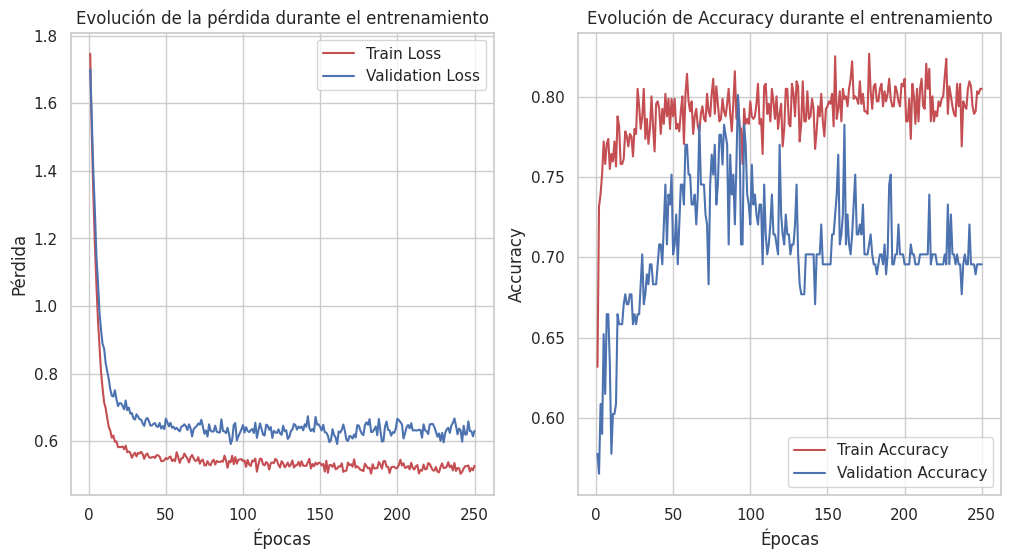

In [335]:
evolucion_perdidas_y_accuracy(history_3)

In [336]:
# métricas de entrenamiento
y_train_pred = (model_3.predict(X_train_balanceado) > 0.5).astype("int32")
metricas(y_train_balanceado, y_train_pred, 'Train')

# métricas de prueba
y_test_pred = (model_3.predict(X_test_estand) > 0.5).astype("int32")
metricas(y_test, y_test_pred, 'Test')

26/26 [==============================] - 0s 2ms/step

 Train Metrics:
Accuracy: 0.7880
Precision: 0.8448
Recall: 0.7057


Classification Report: 

              precision    recall  f1-score   support

           0       0.75      0.87      0.80       401
           1       0.84      0.71      0.77       401

    accuracy                           0.79       802
   macro avg       0.80      0.79      0.79       802
weighted avg       0.80      0.79      0.79       802


5/5 [==============================] - 0s 3ms/step

 Test Metrics:
Accuracy: 0.7078
Precision: 0.5676
Recall: 0.7636


Classification Report: 

              precision    recall  f1-score   support

           0       0.84      0.68      0.75        99
           1       0.57      0.76      0.65        55

    accuracy                           0.71       154
   macro avg       0.70      0.72      0.70       154
weighted avg       0.74      0.71      0.71       154




Aunque este último modelo muestra un ligero aumento en el accuracy en comparación con los anteriores, la precisión general sigue siendo baja.

Podríamos decir que la capacidad predictiva de este último modelo no llega a ser buena, sino que es decente. Aunque hay una mejora leve en el rendimiento, aún se debe mejorar la precisión y la capacidad de generalización del modelo.

# Conclusiones

El dataset con el que hemos trabajado para este ejercicio del Trabajo Práctico presentó varios de desafíos que consideramos que afectaron el rendimiento de los modelos de redes neuronales que implementamos.

En primer lugar, la presencia de una gran cantidad de valores faltantes nos llevó a tener que imputar por la mediana de cada clase, lo cual puede reducir la precisión de los modelos.

Además, las clases estaban desbalanceadas, con la clase positiva (diabética) representando sólo la mitad de los datos en comparación con la clase negativa (no diabética). Para abordar este desequilibrio, hemos tenido que aplicar una técnica de balanceo basada en oversampling, lo que implicó duplicar un gran número de observaciones. Esta práctica también puede afectar la precisión de los modelos.

Otro aspecto a considerar es que el dataset tiene relativamente pocas observaciones y características. Esto hace que el dataset sea relativamente simple y puede limitar la capacidad de los modelos para capturar relaciones complejas entre las características y la variable objetivo.

En cuanto a la arquitectura de los modelos de redes neuronales, hemos observado que es importante la simplicidad. Modelos con una gran cantidad de capas y neuronas tienden a tener un rendimiento deficiente para este dataset, con una variación considerable en los errores y la precisión en cada iteración. Es por eso que hemos optado por arquitecturas más simples al definir los tres modelos que implementamos.

Luego de probar varios modelos de redes neuronales (que no hemos incluido en el trabajo), hemos concluido que la aplicación de técnicas de regularización y dropout es fundamental para evitar el sobreajuste que observamos en el primer modelo.

En general, los resultados de los modelos de redes neuronales que implementamos muestran una capacidad predictiva decente, pero no la consideramos buena. Además, notamos que los modelos tienden a tener una mejor capacidad para predecir casos negativos (personas no diabéticas) en comparación con casos positivos (personas diabéticas).

Creemos que es posible mejorar la capacidad predictiva de los modelos si se tuvieran en cuenta ciertas cuestiones.  Una opción sería aumentar la cantidad de observaciones en el dataset, especialmente enfocándose en obtener más datos de personas diabéticas, lo que permitiría evitar la necesidad de balancear las clases y podría mejorar la capacidad del modelo para aprender de la clase minoritaria.

Además, se podría probar agregando más características, lo cual podría ayudar al modelo a capturar relaciones más complejas entre las características y la variable objetivo.

Una última estrategia que se nos ocurre puede ser la optimización de hiperparámetros. Definir una función que busque los mejores hiperparámetros para la red neuronal podría ayudar a encontrar configuraciones óptimas que maximicen el rendimiento del modelo.